In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")

print("Dataset baixado em:", path)

#https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data

Using Colab cache for faster access to the 'cbis-ddsm-breast-cancer-image-dataset' dataset.
Dataset baixado em: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset


In [3]:
from google.colab import drive
import os

# Monta o Google Drive na máquina virtual do Colab
drive.mount('/content/drive')

# Verifica se o arquivo está lá
zip_path = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'

if os.path.exists(zip_path):
    print("Arquivo zip encontrado com sucesso!")
else:
    print(f"ERRO: Não encontrei o arquivo em {zip_path}. Verifique o nome da pasta/arquivo no Drive.")

Mounted at /content/drive
Arquivo zip encontrado com sucesso!


In [8]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import cv2
import pywt
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# --- 1. CONFIGURAÇÃO E EXTRAÇÃO ---
# Caminho da imagem
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Descompactação concluída.")
    except Exception as e:
        print(f"Erro ao descompactar: {e}")
        exit() # Para se der erro
else:
    print("Arquivos já descompactados anteriormente.")

# --- 2. MAPEAMENTO E PREPARAÇÃO DO DATASET (MODO POR PASTA/UID) ---
print("Localizando e processando metadados (CSVs)...")

csv_train = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_train_set.csv"), recursive=True)
csv_test = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_test_set.csv"), recursive=True)

if not csv_train:
    raise FileNotFoundError("CSV de treino não encontrado.")

df = pd.read_csv(csv_train[0])
if csv_test:
    df_test = pd.read_csv(csv_test[0])
    df = pd.concat([df, df_test], ignore_index=True)

# Mapeamento de Classes
def get_article_label(pathology):
    if 'MALIGNANT' in pathology: return 'Malignant'
    if 'BENIGN_WITHOUT_CALLBACK' in pathology: return 'Normal'
    if 'BENIGN' in pathology: return 'Benign'
    return None

df['label'] = df['pathology'].apply(get_article_label)
df = df.dropna(subset=['label'])

# --- INDEXA POR NOME DA PASTA (UID) ---
print("Indexando imagens pelo ID da pasta...")
folder_map = {}

# Varre todas as pastas e guarda onde estão as imagens JPG
for root, dirs, files in os.walk(EXTRACT_PATH):
    # Filtra apenas arquivos de imagem
    images_in_folder = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images_in_folder:
        # O nome da pasta atual (aquele numero 1.3.6.1.4...) será a chave
        folder_name = os.path.basename(root)

        # Guarda o caminho completo das imagens dessa pasta
        full_paths = [os.path.join(root, img) for img in images_in_folder]
        folder_map[folder_name] = full_paths

print(f"Total de pastas com imagens encontradas: {len(folder_map)}")

# Cruzamento CSV <-> Imagem
valid_data = []
print("Cruzando dados (Buscando ID da pasta do CSV no disco)...")

for idx, row in df.iterrows():
    # Preferência: Imagem Recortada (ROI) > Imagem Completa
    # O CSV tem caminhos tipo: "Mass-Training_.../1.3.6.1.4.1...UID.../000000.dcm"
    paths_to_try = [row.get('cropped image file path'), row.get('image file path')]

    found_filepath = None

    for csv_path in paths_to_try:
        if pd.isna(csv_path): continue

        # Quebra o caminho do CSV em partes (separado por /)
        # Ex: ['Mass-Training...', '1.3.6.1.4.1.9590...', '1.3.6.1.4.1.9590...', '000000.dcm']
        path_parts = csv_path.split('/')

        # Verifica se alguma parte desse caminho corresponde a uma pasta que achamos no disco
        for part in path_parts:
            if part in folder_map:
                candidates = folder_map[part]

                # SE TIVER MAIS DE UMA IMAGEM NA PASTA (Caso da sua imagem 3: ROI + Máscara)
                # Pega a maior imagem (geralmente a textura do ROI é maior que a máscara binária)
                if len(candidates) > 1:
                    try:
                        # Pega o arquivo com maior tamanho em bytes (evita pegar a máscara preta)
                        found_filepath = max(candidates, key=os.path.getsize)
                    except:
                        found_filepath = candidates[0]
                else:
                    found_filepath = candidates[0]

                break

        if found_filepath: break

    if found_filepath:
        valid_data.append({'filepath': found_filepath, 'label': row['label']})

df_final = pd.DataFrame(valid_data)

# --- VERIFICAÇÃO FINAL ---
if len(df_final) == 0:
    print("\nERRO CRÍTICO PERSISTE.")
    print("Debug - Chaves encontradas no disco (exemplo):", list(folder_map.keys())[:3])
    print("Debug - Caminho no CSV (exemplo):", df.iloc[0]['image file path'])
    raise ValueError("Não foi possível casar as pastas do CSV com as pastas do disco.")

print(f"SUCESSO! Total de imagens vinculadas: {len(df_final)}")
print("Distribuição:\n", df_final['label'].value_counts())

# Divisão Treino/Teste
train_df, val_df = train_test_split(df_final, test_size=0.3, stratify=df_final['label'], random_state=42)

Arquivos já descompactados anteriormente.
Localizando e processando metadados (CSVs)...
Indexando imagens pelo ID da pasta...
Total de pastas com imagens encontradas: 6774
Cruzando dados (Buscando ID da pasta do CSV no disco)...
SUCESSO! Total de imagens vinculadas: 1696
Distribuição:
 label
Malignant    784
Benign       771
Normal       141
Name: count, dtype: int64


In [10]:
# --- 3. PIPELINE DE PRÉ-PROCESSAMENTO E GERADORES ---

# Definição das funções de filtro conforme o artigo
def process_pipeline(image_path):
    # Leitura
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((224,224,3)) # Fallback

    # Redimensiona para entrada da GoogleNet
    img = cv2.resize(img, (224, 224))

    # A) Otsu Thresholding (Remoção de Fundo)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener Filter (Remoção de Ruído)
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE Filter (Realce de Contraste)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet Packet Decomposition (db3, nível 2)
    # Nota: Simplificado para reconstrução direta para manter compatibilidade com input RGB
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]]) # Suavização (Denoising)
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB (GoogleNet exige 3 canais)
    img = cv2.resize(img, (224, 224)) # Garante dimensão após wavelet
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) / 255.0

# Classe do Gerador (Keras Sequence)
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=10): # Batch 10
        self.df = df
        self.batch_size = batch_size
        self.le = LabelEncoder()
        # Ajusta para garantir que as classes sejam 0, 1, 2
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.n_classes = 3
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath'])
            X.append(processed_img)
            y.append(row['enc'])
        return np.array(X), to_categorical(y, num_classes=3)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Instancia os geradores (CRIA O train_gen)
print("Criando geradores de dados...")
train_gen = DDSMGenerator(train_df, batch_size=10)
val_gen = DDSMGenerator(val_df, batch_size=10)
print("Geradores prontos!")

Criando geradores de dados...
Geradores prontos!


In [11]:
from sklearn.utils import class_weight

# Extrai os labels numéricos do dataframe de treino
y_train_indices = train_gen.df['enc'].values

# Calcula pesos baseados na frequência (balanced)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# Cria dicionário para o Keras
weights_dict = dict(enumerate(class_weights))

print("Pesos calculados para equilibrar o treinamento:")
for idx, weight in weights_dict.items():
    class_name = train_gen.le.inverse_transform([idx])[0]
    print(f"Classe {class_name}: {weight:.4f}")
# Exemplo esperado: Normal deve ter peso alto (>1.0), Malignant/Benign peso baixo.

Pesos calculados para equilibrar o treinamento:
Classe Benign: 0.7341
Classe Malignant: 0.7207
Classe Normal: 3.9966


Visualizando 5 imagens pré-processadas (Input da Rede):


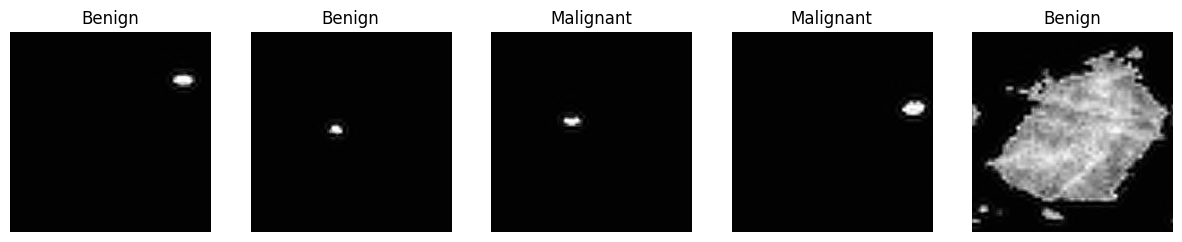

In [12]:
import matplotlib.pyplot as plt

# Pega um lote de teste
X_batch, y_batch = train_gen.__getitem__(0)

plt.figure(figsize=(15, 5))
print(f"Visualizando 5 imagens pré-processadas (Input da Rede):")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_batch[i])
    label_idx = np.argmax(y_batch[i])
    label_name = train_gen.le.inverse_transform([label_idx])[0]
    plt.title(label_name)
    plt.axis('off')
plt.show()

In [13]:
# --- 4. REDE NEURAL E TREINAMENTO ---
print("\nInicializando GoogleNet (InceptionV3)...")

# Base model (pesos da ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Camadas de classificação customizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Dropout 50% para evitar overfitting
x = Dense(1024, activation='relu')(x) # Camada densa
predictions = Dense(3, activation='softmax')(x) # 3 classes: Normal, Benign, Malignant

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação: Adam com LR=0.0001
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Iniciando treinamento...")
# Treinamento usando os pesos de classe calculados
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, # Recomendado 10 a 30 épocas inicial, artigo usa até 100
    class_weight=weights_dict, # Aplica a correção de desbalanceamento
    verbose=1
)

print("Treinamento concluído.")


Inicializando GoogleNet (InceptionV3)...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 790s 6s/step - accuracy: 0.3646 - loss: 1.2468 - val_accuracy: 0.4460 - val_loss: 1.1170
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 721s 6s/step - accuracy: 0.3949 - loss: 1.1301 - val_accuracy: 0.4340 - val_loss: 1.0812
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 725s 6s/step - accuracy: 0.4278 - loss: 1.0290 - val_accuracy: 0.3540 - val_loss: 1.1564
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 722s 6s/step - accuracy: 0.4263 - loss: 0.9928 - val_accuracy: 0.5160 - val_loss: 0.9513
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 712s 6s/step - accuracy: 0.5165 - loss: 0.8708 - val_accuracy: 0.3900 - val_loss: 1.4618
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 714s 6s/step - accuracy: 0.4396 - loss: 0.9210 - val_accuracy: 0.4100 - val_loss: 1.0684
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 719s 6s/step - accuracy: 0.4746 - loss: 0.9123 - val_accuracy: 0.4960 - val_loss: 1.0555
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 721s 6s/step - accuracy: 0.5097 - loss: 0.8796 - val_accu